In [1]:
from spacepy import pycdf
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [84]:
limit = 365 # latch to this many CDF files for testing. Each CDF is a day of champ data.
champ_root_dir = "/Users/patrick/Dev/perceptive_techeval/data/champ-2002-2007/champ-2007/"

df_arr = []
processed = 0
for root, dirs, files in os.walk(os.path.abspath(champ_root_dir)):
    for file in [os.path.join(root, f) for f in files[0:limit] if f.endswith(".cdf")]:
        cdf = pycdf.CDF(file)
        alt = cdf["altitude"][:]/1000.0
        lat = cdf["latitude"][:]
        lon = cdf["longitude"][:]
        lst = cdf["local_solar_time"][:]
        valid = cdf["validity_flag"][:]
        density = cdf["density"][:]
        density_orbitmean = cdf["density_orbitmean"][:]
        time = cdf["time"][:]

        unix_timestamps = [dt.timestamp() for dt in time]
        density[density > 1e30] = np.nan # 1e30 is a stand-in for nan for these data. 
        delta_density = cdf["density"][:] - cdf["density_orbitmean"][:]


        df = pl.DataFrame({
            "timestamp": unix_timestamps, 
            "altitude": alt, 
            "latitude": lat, 
            "longitude": lon, 
            "local_solar_time": lst, 
            "validity_flag": valid, 
            "density_orbitmean": density_orbitmean,
            "density": density, 
            "delta_density": delta_density
        })

        df = df.with_columns([
            (2 * np.pi * df["local_solar_time"] / 24).sin().alias("lst_sin"),
            (2 * np.pi * df["local_solar_time"] / 24).cos().alias("lst_cos")
        ])

        df_arr.append(df)
        
        processed += 1 
        if processed >= limit:
            break
        
df = pl.concat(df_arr)

In [85]:
df

timestamp,altitude,latitude,longitude,local_solar_time,validity_flag,density_orbitmean,density,delta_density,lst_sin,lst_cos
f64,f64,f64,f64,f64,i8,f64,f64,f64,f64,f64
1.1955e9,363.735018,-63.969321,123.038927,8.448712,0,1.3856e-12,1.1696e-12,-2.1600e-13,0.801455,-0.598054
1.1955e9,363.523534,-63.320587,123.155861,8.459285,0,1.3861e-12,1.1738e-12,-2.1226e-13,0.799797,-0.600271
1.1955e9,363.308092,-62.671597,123.265817,8.469393,0,1.3865e-12,1.1843e-12,-2.0221e-13,0.798206,-0.602385
1.1955e9,363.088786,-62.022361,123.36928,8.479068,0,1.3870e-12,1.1965e-12,-1.9048e-13,0.796677,-0.604405
1.1955e9,362.865709,-61.372889,123.466692,8.488339,0,1.3875e-12,1.2013e-12,-1.8617e-13,0.795208,-0.606337
…,…,…,…,…,…,…,…,…,…,…
1.1825e9,347.726704,-10.67271,157.259499,10.439329,0,1.3442e-12,1.5880e-12,2.4385e-13,0.397309,-0.917685
1.1825e9,347.912518,-11.33175,157.250523,10.441508,0,1.3443e-12,1.5871e-12,2.4282e-13,0.396786,-0.917911
1.1825e9,348.102475,-11.990727,157.241696,10.443697,0,1.3444e-12,1.5866e-12,2.4218e-13,0.39626,-0.918139


Assumed Alpha: 0
Mean Squared Error (MSE): 2.483545734916992e-25
Mean Absolute Error (MAE): 3.9880446886323734e-13
R² Score: 0.48759920690249103


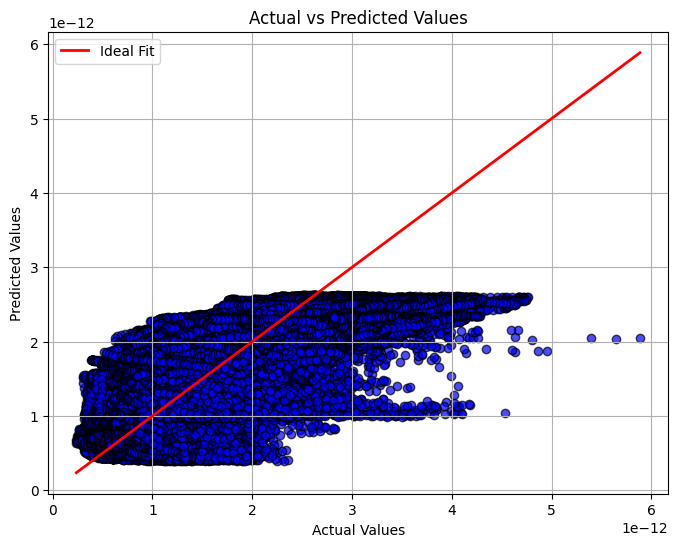

In [86]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define test ratio and random seed
test_ratio = 0.10
random_seed = 123
assumed_alpha = 0  # Assumed alpha value for SGDRegressor

# Create the mask to filter valid data
mask = (~df["density"].is_null()) & (df["validity_flag"] == 0)

# Select features and target variable (without timestamp)
X = df.filter(mask).select(["timestamp","latitude","longitude","altitude", "lst_sin", "lst_cos"]).to_numpy()
y = df.filter(mask)["density"].to_numpy()

# Split data into training/validation and test sets
test_size = int(len(X) * test_ratio)
X_train_val, X_test = X[:-test_size], X[-test_size:]
y_train_val, y_test = y[:-test_size], y[-test_size:]

# Create the pipeline with assumed alpha value
pipeline = make_pipeline(StandardScaler(),
                         SGDRegressor(max_iter=1000, tol=1e-3, alpha=assumed_alpha, random_state=random_seed))

pipeline.fit(X_train_val, y_train_val)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Assumed Alpha: {assumed_alpha}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


In [72]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

test_ratio = 0.10
random_seed = 123

mask = (~df["density"].is_null()) & (df["validity_flag"] == 0)
X = df.filter(mask).select(["timestamp","altitude","lst_sin","lst_cos"]).to_numpy()
y = df.filter(mask)["density"].to_numpy()

test_size = int(len(X) * test_ratio)
X_train_val, X_test = X[:-test_size], X[-test_size:]
y_train_val, y_test = y[:-test_size], y[-test_size:]

tscv = TimeSeriesSplit(n_splits=5)

pipeline = make_pipeline(StandardScaler(),
                         SGDRegressor(max_iter=1000, tol=1e-3, random_state=random_seed))
param_grid = {
    "sgdregressor__alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    verbose=4
)

grid_search.fit(X_train_val, y_train_val)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_["sgdregressor__alpha"]

print("best alpha: " + str(best_alpha))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ........sgdregressor__alpha=1e-06;, score=-0.000 total time=   0.3s
[CV 2/5] END ........sgdregressor__alpha=1e-06;, score=-0.000 total time=   1.2s
[CV 3/5] END ........sgdregressor__alpha=1e-06;, score=-0.000 total time=   1.0s
[CV 4/5] END ........sgdregressor__alpha=1e-06;, score=-0.000 total time=   1.3s
[CV 5/5] END ........sgdregressor__alpha=1e-06;, score=-0.000 total time=   1.6s
[CV 1/5] END ........sgdregressor__alpha=1e-05;, score=-0.000 total time=   0.3s
[CV 2/5] END ........sgdregressor__alpha=1e-05;, score=-0.000 total time=   0.6s
[CV 3/5] END ........sgdregressor__alpha=1e-05;, score=-0.000 total time=   0.9s
[CV 4/5] END ........sgdregressor__alpha=1e-05;, score=-0.000 total time=   1.2s
[CV 5/5] END ........sgdregressor__alpha=1e-05;, score=-0.000 total time=   1.6s
[CV 1/5] END .......sgdregressor__alpha=0.0001;, score=-0.000 total time=   0.3s
[CV 2/5] END .......sgdregressor__alpha=0.0001;, 

Mean Squared Error (MSE): 1.7777145966096077e-24
Mean Absolute Error (MAE): 1.056055331289834e-12
R² Score: 0.5751907737715891


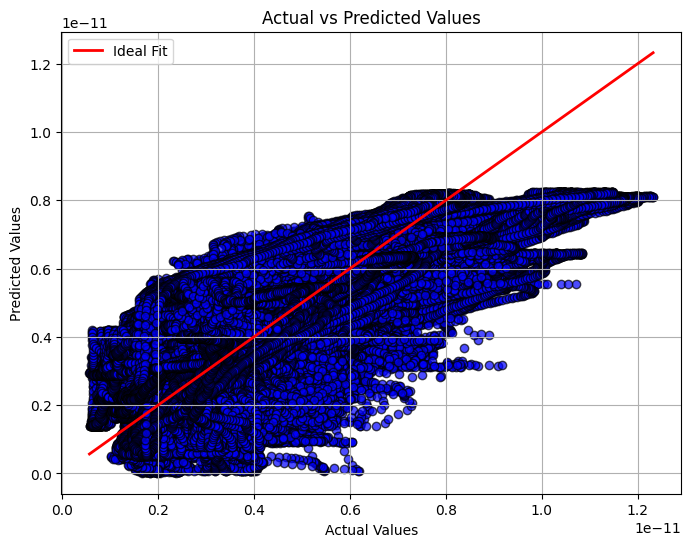

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

Random Forest Mean Squared Error (MSE): 2.0665053039792397e-24
Random Forest Mean Absolute Error (MAE): 9.596179653181508e-13
Random Forest R² Score: -0.21612491628997543


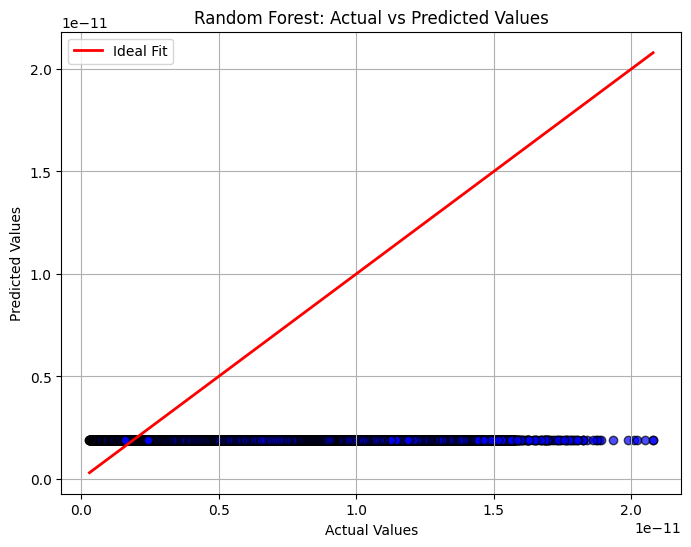

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=random_seed)

# Fit the model to the training data
rf.fit(X_train_val, y_train_val)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Calculate evaluation metrics on the test set
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest R² Score: {r2_rf}")

# Plot the Actual vs Predicted values for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Random Forest: Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


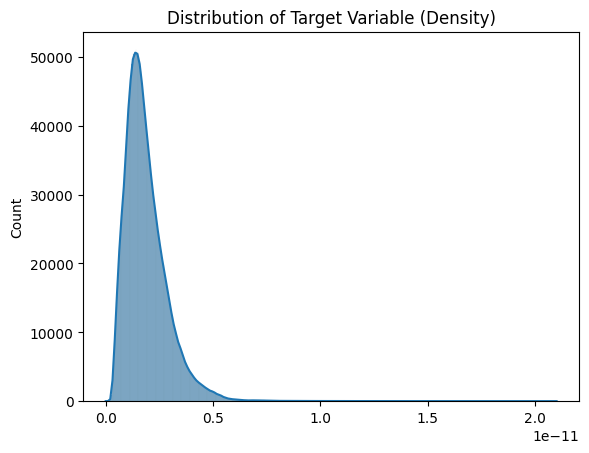

In [23]:
import seaborn as sns

sns.histplot(y_train_val, kde=True)
plt.title("Distribution of Target Variable (Density)")
plt.show()

In [24]:
feature_importance = rf.feature_importances_
features = ['timestamp', 'altitude', 'latitude', 'longitude', 'local_solar_time']
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort and print
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

            Feature  Importance
0         timestamp         0.0
1          altitude         0.0
2          latitude         0.0
3         longitude         0.0
4  local_solar_time         0.0


In [ ]:
best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
random_seed = 123

X = np.array(df["altitude","latitude","longitude","local_solar_time"])
y = np.array(df["density"])

mask = (~df["density"].is_null()) & (df["validity_flag"] == 0)
X = df.filter(mask).select(["altitude", "latitude", "longitude", "local_solar_time"]).to_numpy()
y = df.filter(mask)["density"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=random_seed) # train, test, validation splits
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=random_seed) 

pipeline = make_pipeline(StandardScaler(),
                         XGBRegressor(random_state=random_seed))

param_grid = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=random_seed), scoring="neg_mean_squared_error", verbose=2, n_jobs=4)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=123, ...))])

Mean Squared Error (MSE): 2.389165279556491e-24
Mean Absolute Error (MAE): 1.1200237983809136e-12
R² Score: -5.533057789719464e-09


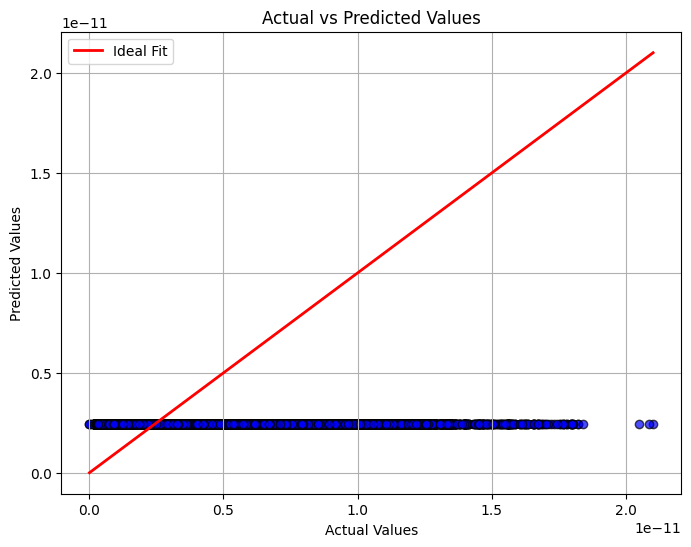

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()